# Recurrent Neural Network

A Recurrent is Similar to a neural network, But it has an internal Loop that allows them to analyse more optimaly a sequence of data. This makes them Really good for time series analsys,  sentence and speech recognition

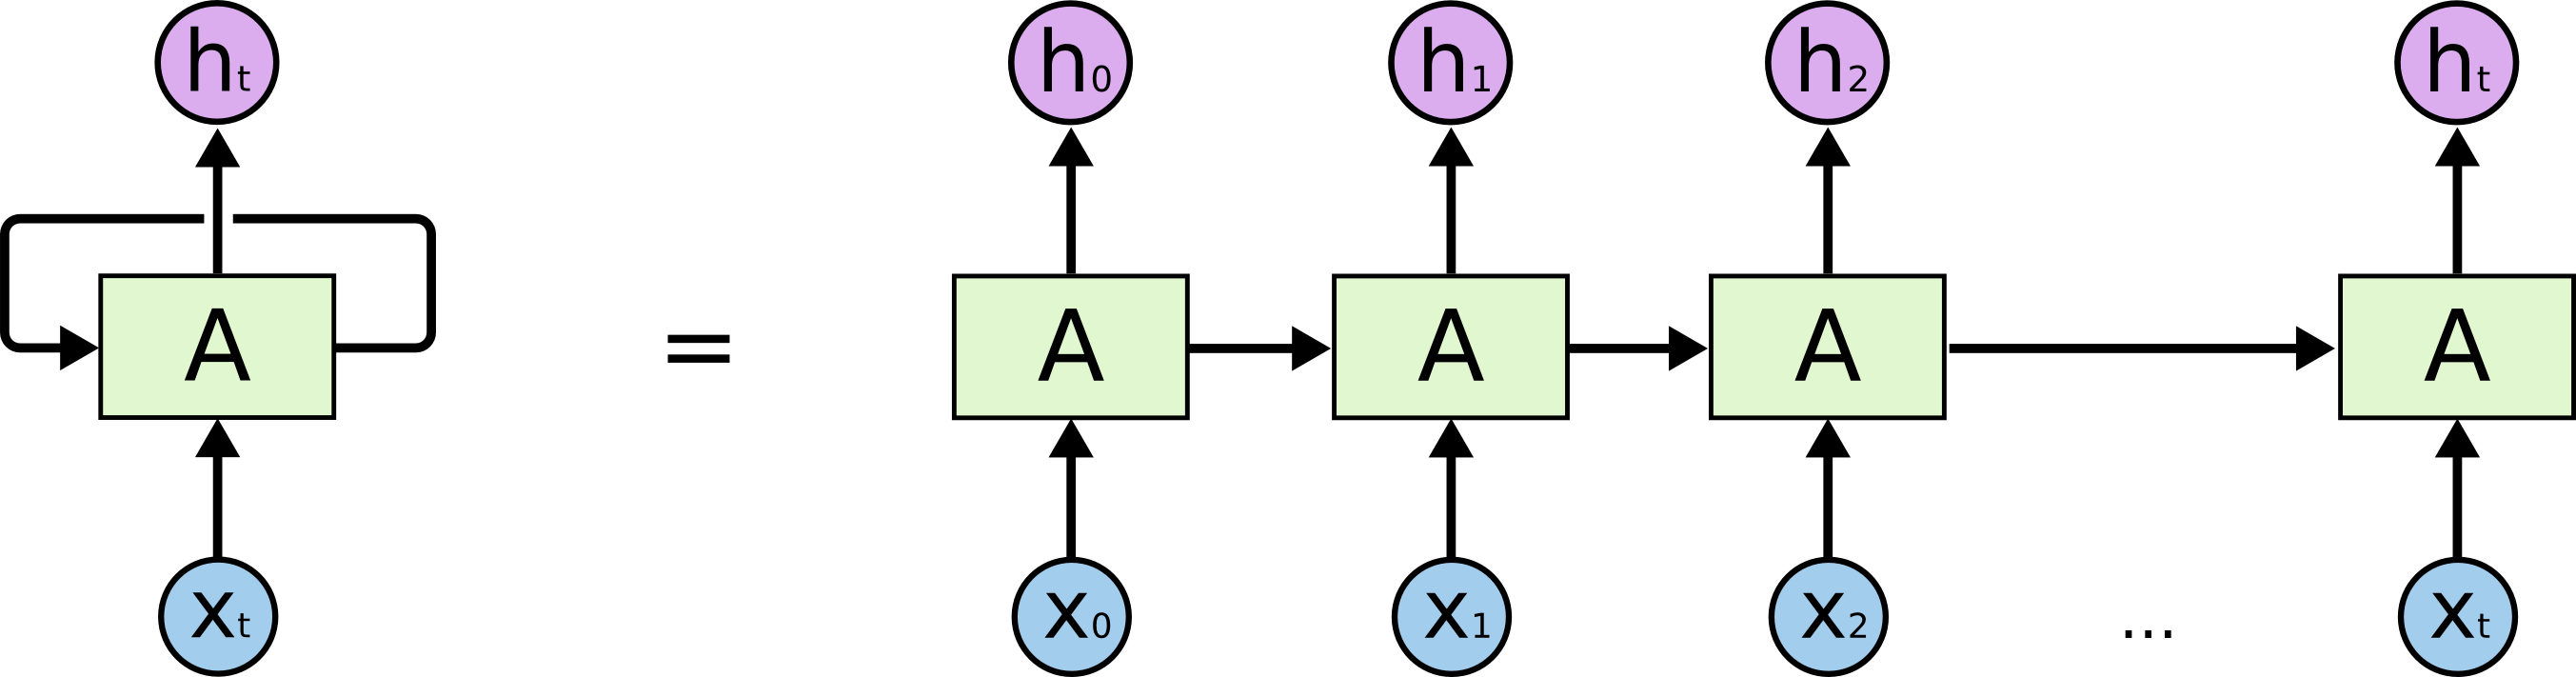

Long Short Term Memory networks, usually just called “LSTMs” are a special kind of RNN, capable of learning long-term dependencies. A RNN is unable to make relation between old and recent event. LSTM improve this model by having a more "Trainable memory"

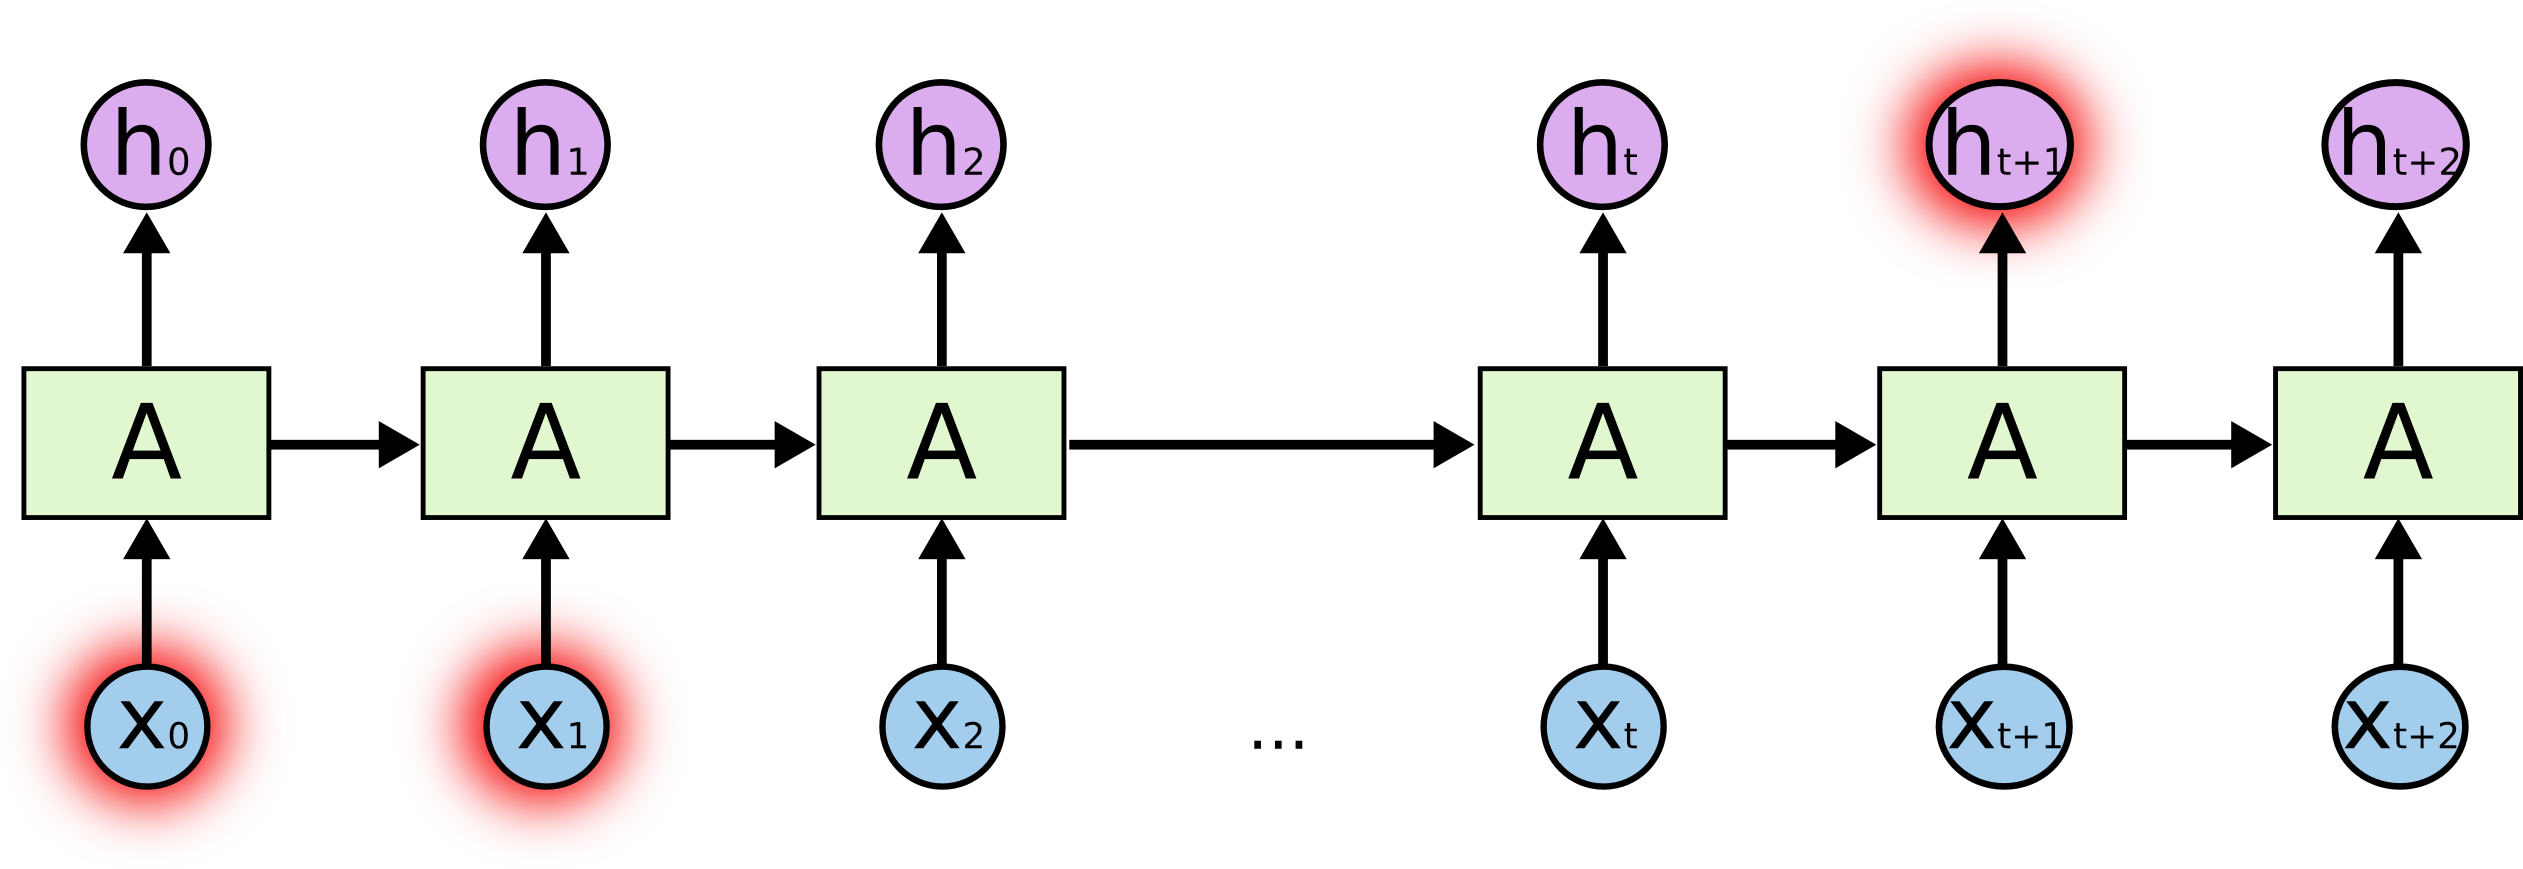

this pictures shows how a LSTM reccurent neuron works.   
basically instead of having a single tanh activation you have a gates (+) 


this means that the neural network  can be trained to link old event with new events
if this happens, when a input pass in this neurons, 


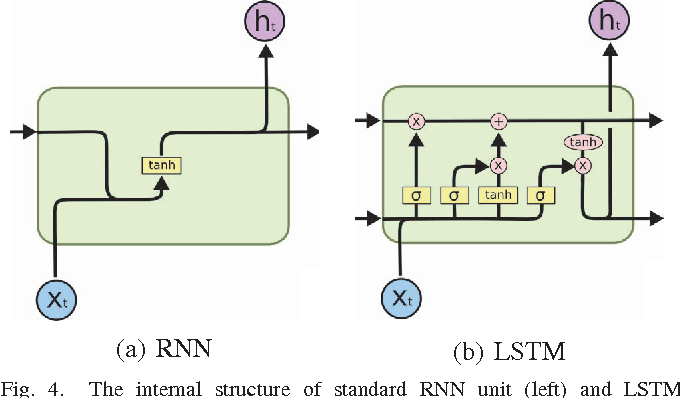

# Base setup


In [ ]:
% matplotlib inline
import pandas as pd
import itertools as itt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.metrics import * 


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_percentage_error(y_true, y_pred):
    return np.mean(( (y_true - y_pred) / y_true)**2) * 100

#Tensorboard visualiser
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Getting data

In [ ]:
dataf = pd.read_csv("../data/featured_proto_traffic.csv")
del dataf['timestamp']
data = dataf.values

n = data.shape[0]
p = data.shape[1]



# Transforming data


In [ ]:
from sklearn.preprocessing import MinMaxScaler

train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n

data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]




In [ ]:
tf.reset_default_graph()
# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128
display_step = 200

# Network Parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 # timesteps
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input],name="InputX")
Y = tf.placeholder("float", [None, num_classes],name="InputY")

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]),name="W-Out")
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]),name="B-Out")
}


def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())

# Modeling

### finding the optimal epoch number

In [ ]:
def plotPredictionResult(prediction,y,title):
    with plt.style.context('seaborn-white'):   
        plt.figure(figsize=(15, 3))
        plt.plot(y, label="actual", linewidth=2.0)
        plt.plot(prediction, label="prediction", linewidth=2.0)
        plt.title(title)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True);
        
def showModelStats(model):
    pred_test = model.run(out, feed_dict={X: X_test})[0]
    pred_train = model.run(out, feed_dict={X: X_train})[0]

    def print_error(pred,real,name):
        print(f"{name}-r2:",r2_score(pred,real))
        print(f"{name}-MAPE:",100 - mean_absolute_percentage_error(pred,real),"%")
        print(f"{name}-MSPE:",100 - mean_squared_percentage_error(pred,real),"%")
        print("="*10)
    
    print_error(pred_train,y_train,"Train")
    plotPredictionResult(pred_train,y_train,title="Train Result")
    
    print_error(pred_test,y_test,"Test")
    plotPredictionResult(pred_test,y_test,title="Test Result")
   
    begin,end = -144*3,-144
    zoom_pred,zoom_test = pred_test[begin:end],y_test[begin:end]
    print_error(zoom_pred,zoom_test,"Test")
    plotPredictionResult(zoom_pred,zoom_test,title="Zoomed Result")


In [ ]:
# the training hasnt been made yet with those data

# this is a sample that has been found on internet. this is currently adapted to my current solution
# and doesnt work yet

with tf.Session() as session:
    session.run(init)
    step = 0
    offset = random.randint(0,n_input+1)
    end_offset = n_input + 1
    acc_total = 0
    loss_total = 0

    writer.add_graph(session.graph)

    while step < training_iters:
        # Generate a minibatch. Add some randomness on selection process.
        if offset > (len(training_data)-end_offset):
            offset = random.randint(0, n_input+1)

        symbols_in_keys = [ [dictionary[ str(X_train[i])]] for i in range(offset, offset+n_input) ]
        symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

        symbols_out_onehot = np.zeros([vocab_size], dtype=float)
        symbols_out_onehot[dictionary[str(X_train[offset+n_input])]] = 1.0
        symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

        _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
        loss_total += loss
        acc_total += acc
        if (step+1) % display_step == 0:
            print("Iter= " + str(step+1) + ", Average Loss= " + \
                  "{:.6f}".format(loss_total/display_step) + ", Average Accuracy= " + \
                  "{:.2f}%".format(100*acc_total/display_step))
            acc_total = 0
            loss_total = 0
            symbols_in = [training_data[i] for i in range(offset, offset + n_input)]
            symbols_out = training_data[offset + n_input]
            symbols_out_pred = reverse_dictionary[int(tf.argmax(onehot_pred, 1).eval())]
            print("%s - [%s] vs [%s]" % (symbols_in,symbols_out,symbols_out_pred))
        step += 1
        offset += (n_input+1)

# Observations

In [ ]:
# TODO